In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from skimage import morphology
from skimage.filters import gaussian

from utils import *

#### L'ensemble des fonctions codées sont disposées dans utils.py par soucis de lisibilité

## Extraction et visualisation des données

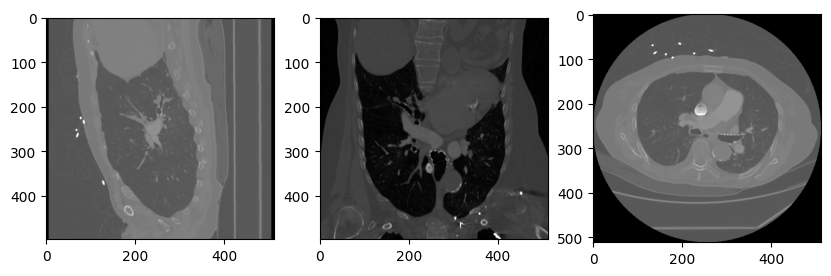

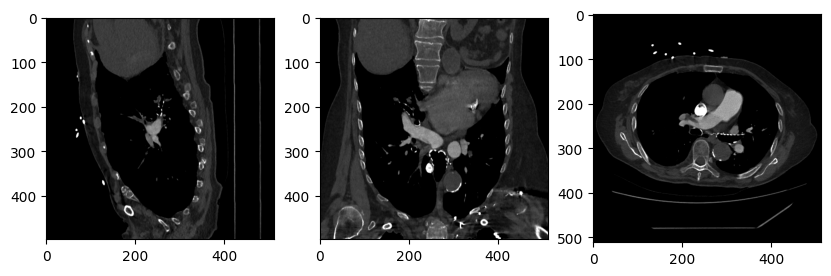

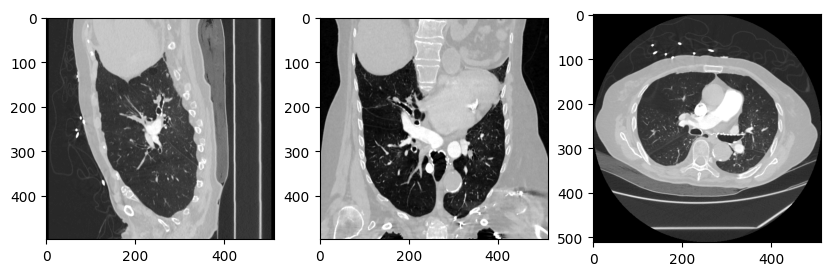

In [2]:
img = extract_dicom(folder_path = "./THORAX_EP_1/")
window_dicom = extract_dicom_and_windowing(folder_path = "./THORAX_EP_1/")
window_manual = apply_windowing(img.copy(), 600, 1700)
plot(img)
plot(window_dicom)
plot(window_manual)

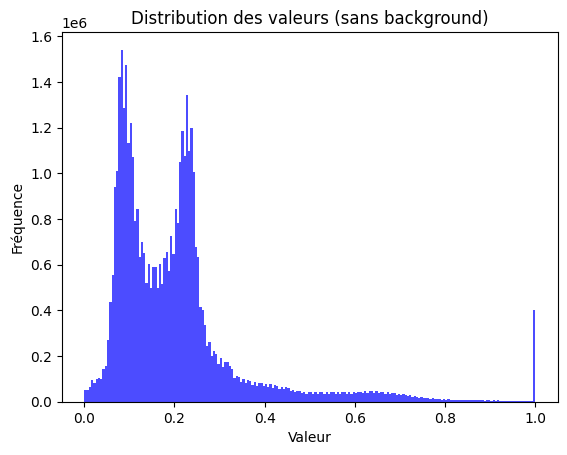

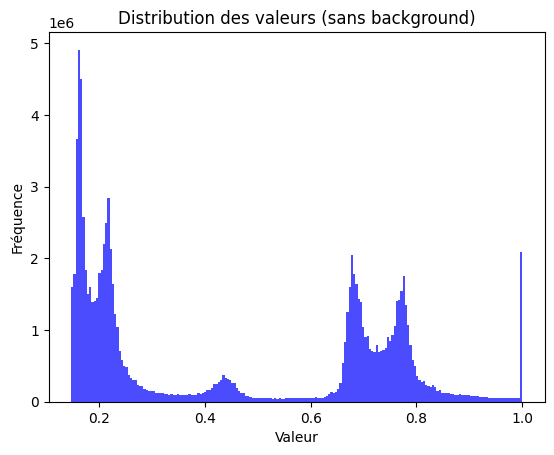

In [3]:
hist_without_background(window_dicom)
hist_without_background(window_manual)

## Segmentation des lobes pulmonaires

In [2]:
def lung_segmentation(img, indice=1):
    pulmonary = apply_windowing(img.copy(), 600, 1700)
    binary = binarize(pulmonary.copy(), 0.35)
    binary = invert(binary)
    close = []
    for i in range(0, binary.shape[0]):
        close.append(morphology.isotropic_closing(binary[i, :, :], 7))

    close = np.array(close)

    particles = selected_particles(close)

    final = pulmonary* particles[indice]

    return particles[indice], final


particle, pulmonary_segmented = lung_segmentation(img)

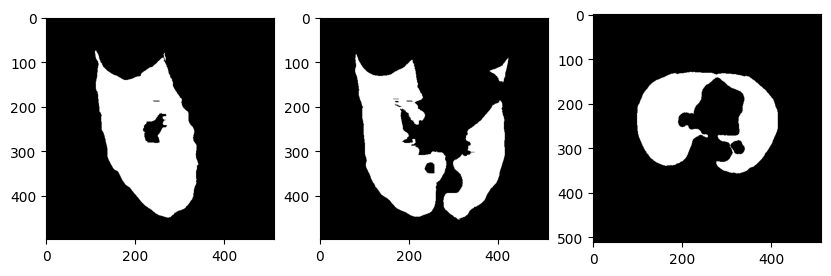

In [4]:
plot(particle)

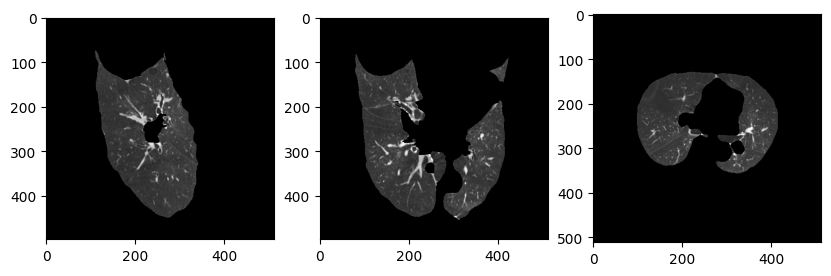

In [6]:
plot(pulmonary_segmented)

## Segmentation de l'arbre vasculaire des lobes pulmonaires

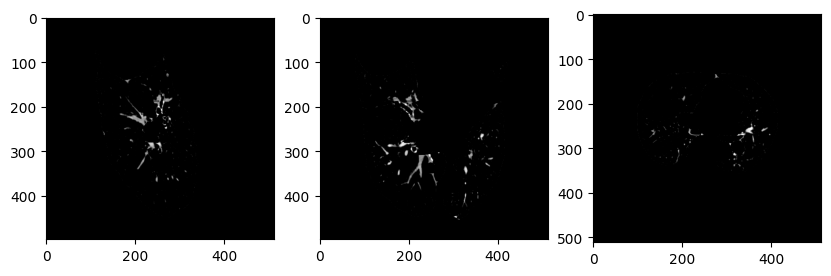

In [7]:
def h_dome(image, h=0.6, sigma_gauss=0.3):
    """ Attention peut être out of memory, à faire sur des sous images"""
    img_filtred = gaussian(image, 0.3) # 1
    img_filtred = np.array(img_filtred, dtype=np.float32)
    image_h = np.clip(img_filtred - h, 0, None)
    seed = np.copy(image_h)
    mask = np.copy(img_filtred)
    dilated = morphology.reconstruction(seed, mask, method='dilation')
    return img_filtred - dilated


h_dome_1 = h_dome(pulmonary_segmented[:250, :, :], h=0.6, sigma_gauss=0.3)
h_dome_2 = h_dome(pulmonary_segmented[250:, :, :], h=0.6, sigma_gauss=0.3)
h_dome_complete = np.concatenate((h_dome_1, h_dome_2), axis=0)

pulmonary = apply_windowing(img.copy(), 600, 1700)

plot(h_dome_complete)

## Segmentation des artères pulmonaires droite et gauche

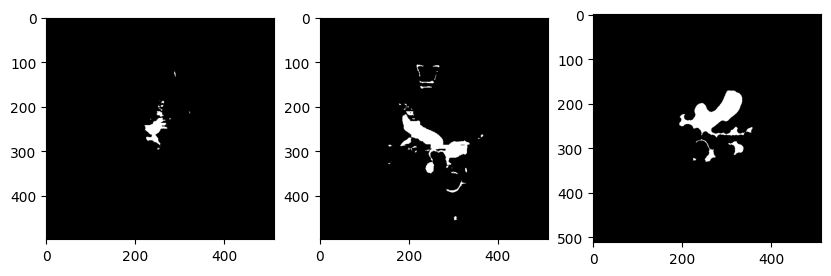

In [3]:
img = extract_dicom(folder_path = "./THORAX_EP_1/")
particle, _ = lung_segmentation(img)

pulmonary = apply_windowing(img.copy(), 600, 1700)
# Fermeture pour récupérer les différents organes et vaisseaux entre les poumons
close = []
for i in range(0, particle.shape[0]):
    close.append(morphology.isotropic_closing(particle[i, :, :], 100))
close = np.array(close)

# Récupération uniquement des organes et vaisseaux ayant une forte intensité (donc du produit de contraste)
test = pulmonary*close
binary = binarize(test.copy(), 0.9)
close_2 = []
for i in range(0, binary.shape[0]):
    close_2.append(morphology.isotropic_closing(binary[i, :, :], 7)) # 6
close_2 = np.array(close_2)
particle = selected_particles(close_2)[0]

plot(particle)

## Fonction récapitulant l'ensemble de la méthode

In [7]:
def vasculary_segmentation(image):
    particle, pulmonary_segmented = lung_segmentation(image, indice=2)
    h_dome_1 = h_dome(pulmonary_segmented[:250, :, :], h=0.6, sigma_gauss=0.3)
    h_dome_2 = h_dome(pulmonary_segmented[250:, :, :], h=0.6, sigma_gauss=0.3)
    h_dome_complete = np.concatenate((h_dome_1, h_dome_2), axis=0)

    pulmonary = apply_windowing(img.copy(), 600, 1700)

    plot(h_dome_complete)

    # Fermeture pour récupérer les différents organes et vaisseaux entre les poumons
    close = []
    for i in range(0, particle.shape[0]):
        close.append(morphology.isotropic_closing(particle[i, :, :], 100))
    close = np.array(close)

    # Récupération uniquement des organes et vaisseaux ayant une forte intensité (donc du produit de contraste)
    test = pulmonary*close
    binary = binarize(test.copy(), 0.9)
    close_2 = []
    for i in range(0, binary.shape[0]):
        close_2.append(morphology.isotropic_closing(binary[i, :, :], 7)) # 6
    close_2 = np.array(close_2)
    particles = selected_particles(close_2)

    min_pulmonary, max_pulmonary = np.min(pulmonary_segmented), np.max(pulmonary_segmented)

    # Trouver les valeurs min et max dans h_dome_completed
    min_hdome, max_hdome = np.min(h_dome_complete), np.max(h_dome_complete)

    # Rescaler h_dome_completed pour correspondre aux intensités de pulmonary
    rescaled_hdome = ((h_dome_complete - min_hdome) / (max_hdome - min_hdome)) * (max_pulmonary - min_pulmonary) + min_pulmonary

    final_segmentation = np.maximum(rescaled_hdome, pulmonary*particles[0])
    plot(final_segmentation)
    return final_segmentation, h_dome_complete, particles[0]
final_segmentation, h_dome_complete, particle = vasculary_segmentation(img)

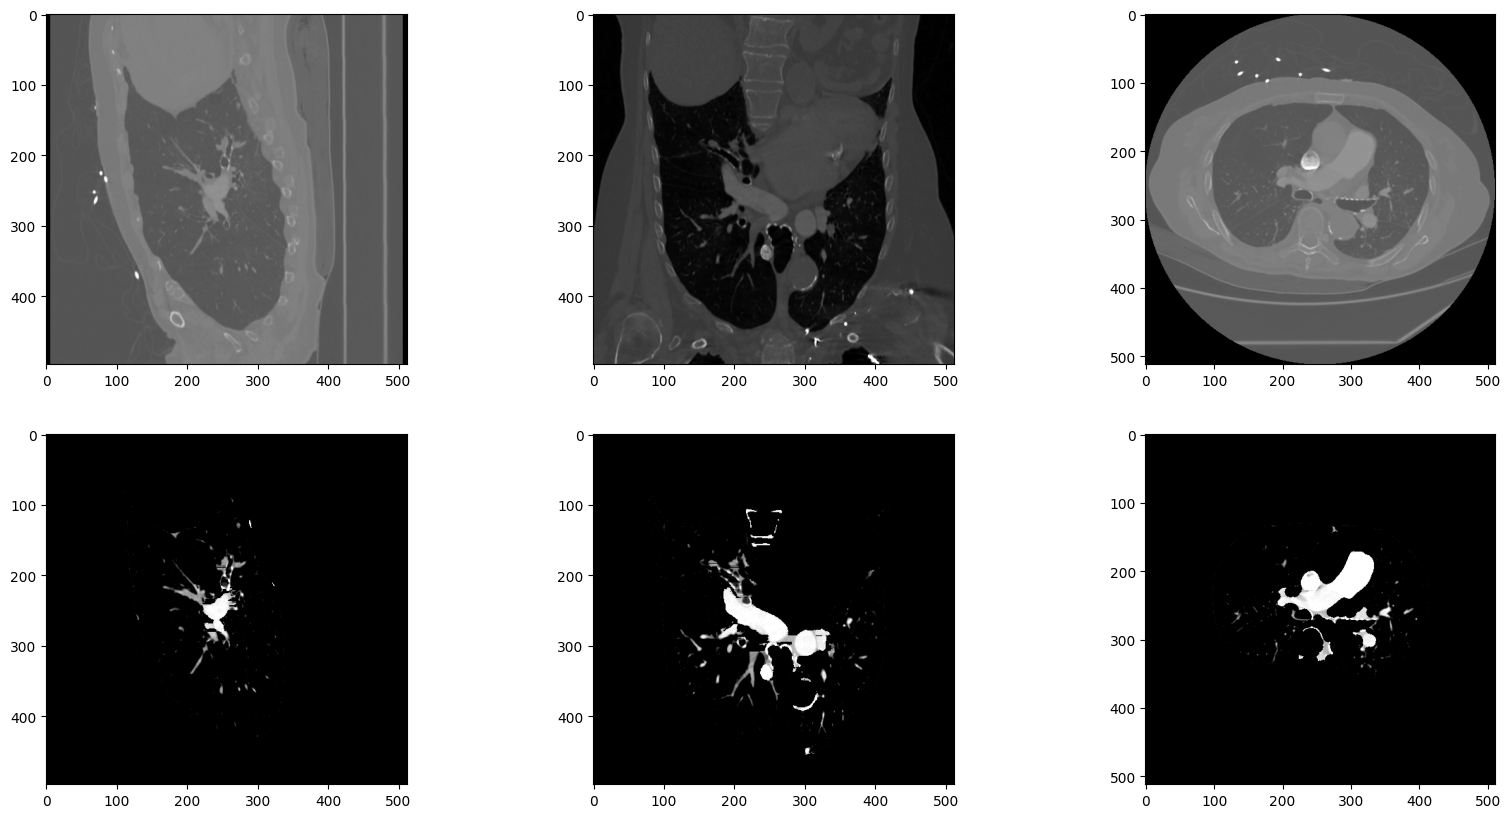

In [28]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
ax[0,0].imshow(img[:, :, 200], cmap="gray")
ax[0,1].imshow(img[:, 250, :], cmap="gray")
ax[0,2].imshow(img[273, :, :], cmap="gray")
ax[1,0].imshow(final_segmentation[:, :, 200], cmap="gray")
ax[1,1].imshow(final_segmentation[:, 250, :], cmap="gray")
ax[1,2].imshow(final_segmentation[273, :, :], cmap="gray")